In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr

# 1. Load Data

In [2]:

# Load Reddit posts data and Google Trends regional data from CSV files
reddit_df = pd.read_csv('mentalhealth_2018_features_tfidf_256.csv')
google_df = pd.read_csv('geoMap.csv')

# 2. Preprocess Reddit Data

In [3]:

print("Initial Reddit Data Shape:", reddit_df.shape)

Initial Reddit Data Shape: (3360, 350)


In [4]:
# Convert the 'date' column to datetime format, coercing errors to NaT
reddit_df['date'] = pd.to_datetime(reddit_df['date'], errors='coerce')

In [5]:
# Drop rows where 'post' or 'date' is missing (NaN)
reddit_df = reddit_df.dropna(subset=['post', 'date'])

In [6]:
# Remove duplicate posts based on 'post' text and 'date' to avoid repeated entries
reddit_df = reddit_df.drop_duplicates(subset=['post', 'date'])
print("Cleaned Reddit Data Shape:", reddit_df.shape)

Cleaned Reddit Data Shape: (3360, 350)


In [7]:
# Inspect top 10 subreddits to understand where most posts are coming from
print("\nTop 10 Subreddits by Post Count:")
print(reddit_df['subreddit'].value_counts().head(10))


Top 10 Subreddits by Post Count:
subreddit
mentalhealth    3360
Name: count, dtype: int64


# 3. Sentiment Analysis using VADER

In [8]:

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
# Calculate compound sentiment score for each post
reddit_df['sentiment_score'] = reddit_df['post'].astype(str).apply(
    lambda text: analyzer.polarity_scores(text)['compound']
)


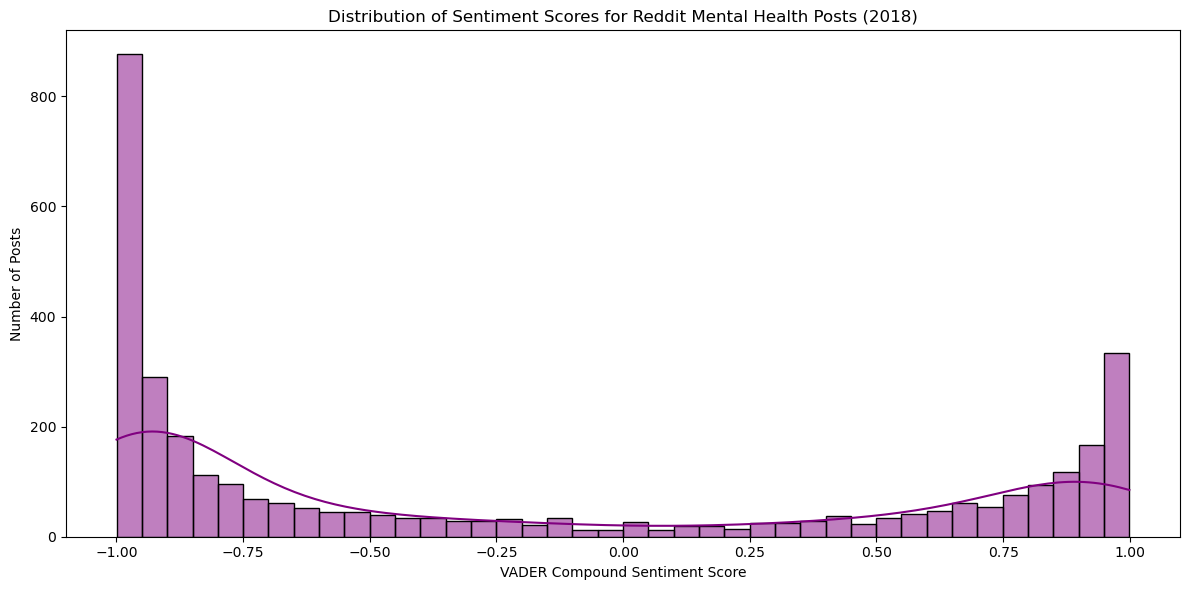

In [9]:
# Plot distribution of sentiment scores across all posts
plt.figure(figsize=(12,6))
sns.histplot(reddit_df['sentiment_score'], bins=40, kde=True, color='purple')
plt.title('Distribution of Sentiment Scores for Reddit Mental Health Posts (2018)')
plt.xlabel('VADER Compound Sentiment Score')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.savefig("reddit_sentiment_distribution.png")
plt.show()

# 4. Weekly Aggregation of Sentiment

In [10]:
# Extract week start dates from post dates for grouping
reddit_df['week'] = reddit_df['date'].dt.to_period('W').dt.start_time

In [11]:
# Calculate mean sentiment score per week
weekly_sentiment = reddit_df.groupby('week')['sentiment_score'].mean().reset_index()

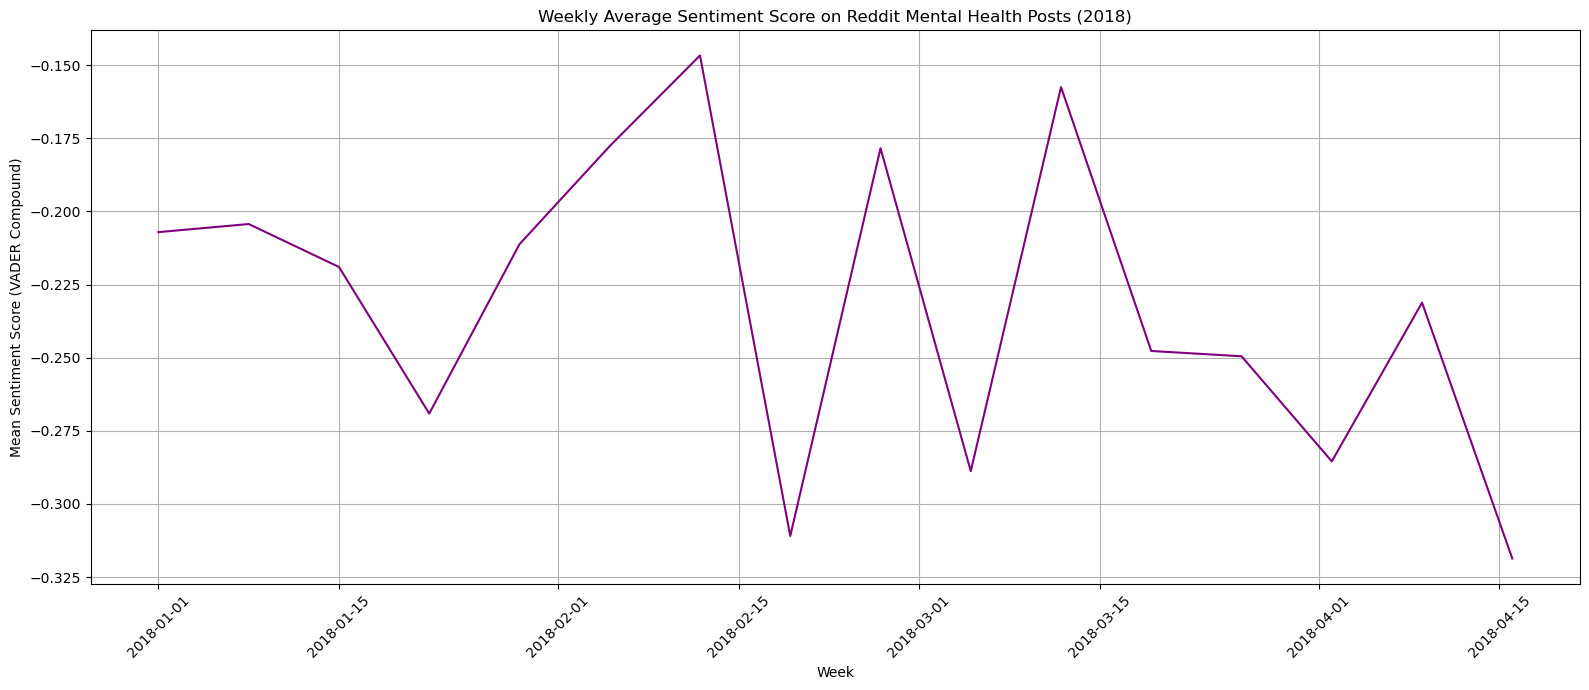

In [12]:
# Plot weekly average sentiment to observe trends over 2018
plt.figure(figsize=(16,7))
sns.lineplot(data=weekly_sentiment, x='week', y='sentiment_score', color='purple')
plt.title('Weekly Average Sentiment Score on Reddit Mental Health Posts (2018)')
plt.xlabel('Week')
plt.ylabel('Mean Sentiment Score (VADER Compound)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("reddit_weekly_sentiment_trend.png")
plt.show()

# 5. Identify weeks with most extreme sentiments for further inspection

In [13]:
most_negative_week = weekly_sentiment.loc[weekly_sentiment['sentiment_score'].idxmin()]
most_positive_week = weekly_sentiment.loc[weekly_sentiment['sentiment_score'].idxmax()]


print(f"\nMost Negative Week: {most_negative_week['week'].date()} with score {most_negative_week['sentiment_score']:.3f}")
print(f"Most Positive Week: {most_positive_week['week'].date()} with score {most_positive_week['sentiment_score']:.3f}")



Most Negative Week: 2018-04-16 with score -0.319
Most Positive Week: 2018-02-12 with score -0.147


# 6. Preprocess Google Trends Regional Data

In [14]:
#  Clean column names by making lowercase, removing ": (2018)", and stripping whitespace
google_df.columns = google_df.columns.str.lower().str.replace(': \(2018\)', '', regex=True).str.strip()

# Convert percentage strings to floats for relevant search terms, handling '<1' as 0.5
for col in ['mental health', 'depression', 'therapy', 'suicide help']:
    google_df[col] = (
        google_df[col]
        .str.replace('%', '', regex=False)
        .replace('<1', '0.5')
        .astype(float)
    )
print("\nGoogle Trends Columns after Cleaning:")
print(google_df.columns.tolist())


Google Trends Columns after Cleaning:
['region', 'mental health', 'depression', 'therapy', 'suicide help']


<>:2: SyntaxWarning: invalid escape sequence '\('
<>:2: SyntaxWarning: invalid escape sequence '\('
/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/4219369191.py:2: SyntaxWarning: invalid escape sequence '\('
  google_df.columns = google_df.columns.str.lower().str.replace(': \(2018\)', '', regex=True).str.strip()


# 7. Visualize Top 10 Regions by Mental Health Search Interest

/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3331358678.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mental health', y='region', data=top_states, palette='Blues_r')


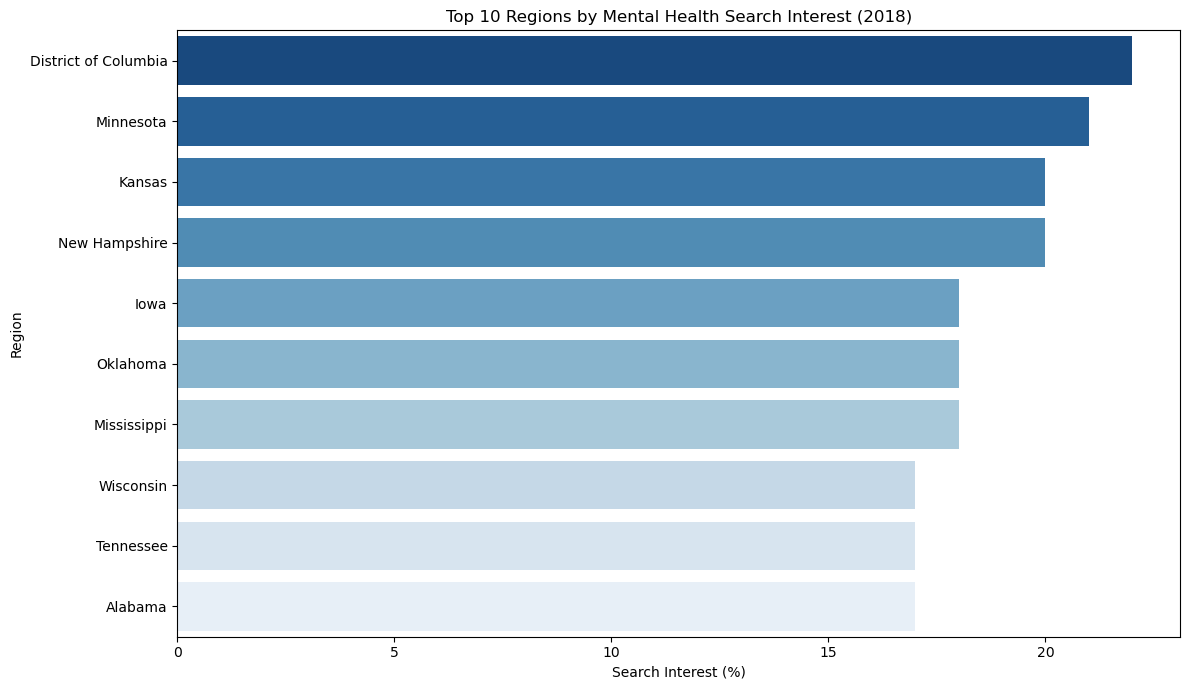


Top 10 Regions by Mental Health Search Interest:
                  region  mental health
0   District of Columbia           22.0
2              Minnesota           21.0
3                 Kansas           20.0
1          New Hampshire           20.0
6                   Iowa           18.0
18              Oklahoma           18.0
8            Mississippi           18.0
11             Wisconsin           17.0
19             Tennessee           17.0
17               Alabama           17.0


In [15]:
# Sort regions by 'mental health' interest descending and take top 10
top_states = google_df.sort_values('mental health', ascending=False).head(10)

plt.figure(figsize=(12,7))
sns.barplot(x='mental health', y='region', data=top_states, palette='Blues_r')
plt.title('Top 10 Regions by Mental Health Search Interest (2018)')
plt.xlabel('Search Interest (%)')
plt.ylabel('Region')
plt.tight_layout()
plt.savefig("google_top_states.png")
plt.show()

print("\nTop 10 Regions by Mental Health Search Interest:")
print(top_states[['region', 'mental health']])

# 8. Correlation Heatmap of Google Trends Terms

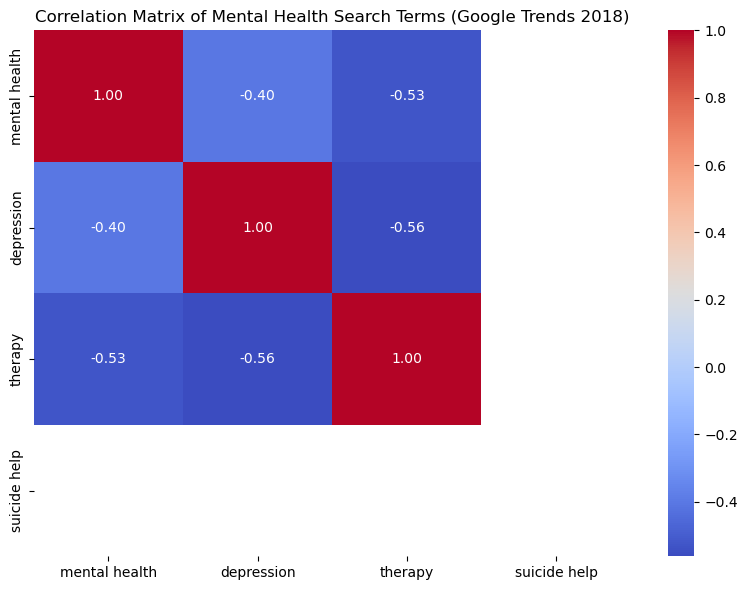


Correlation matrix of Google Trends search terms:
               mental health  depression  therapy  suicide help
mental health           1.00       -0.40    -0.53           NaN
depression             -0.40        1.00    -0.56           NaN
therapy                -0.53       -0.56     1.00           NaN
suicide help             NaN         NaN      NaN           NaN


In [16]:
# Calculate Pearson correlation matrix of the four search terms
corr = google_df[['mental health', 'depression', 'therapy', 'suicide help']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Mental Health Search Terms (Google Trends 2018)")
plt.tight_layout()
plt.savefig("google_trends_correlation_heatmap.png")
plt.show()

print("\nCorrelation matrix of Google Trends search terms:")
print(corr.round(2))

# 9. Statistical Correlation Test (Pearson)

In [17]:
# Perform statistical tests to evaluate significance of correlations
from scipy.stats import pearsonr
import numpy as np

print("\nPearson Correlation Coefficients and p-values:")

for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2:
            # Select only rows where both columns have finite (non-NaN, non-inf) values
            valid_idx = google_df[[col1, col2]].replace([np.inf, -np.inf], np.nan).dropna().index
            clean_x = google_df.loc[valid_idx, col1]
            clean_y = google_df.loc[valid_idx, col2]
            
            # Now calculate Pearson correlation safely
            r, p = pearsonr(clean_x, clean_y)
            print(f"{col1} vs {col2}: r = {r:.2f}, p = {p:.4f}")



Pearson Correlation Coefficients and p-values:
mental health vs depression: r = -0.40, p = 0.0033
mental health vs therapy: r = -0.53, p = 0.0001
mental health vs suicide help: r = nan, p = nan
depression vs mental health: r = -0.40, p = 0.0033
depression vs therapy: r = -0.56, p = 0.0000
depression vs suicide help: r = nan, p = nan
therapy vs mental health: r = -0.53, p = 0.0001
therapy vs depression: r = -0.56, p = 0.0000
therapy vs suicide help: r = nan, p = nan
suicide help vs mental health: r = nan, p = nan
suicide help vs depression: r = nan, p = nan
suicide help vs therapy: r = nan, p = nan


/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3319835089.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(clean_x, clean_y)
/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3319835089.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(clean_x, clean_y)
/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3319835089.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(clean_x, clean_y)
/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3319835089.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(clean_x, clean_y)
/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3319835089.py:16: ConstantInputWarning: An input array is constant; the correlation

# 10. Reddit Subreddit-level Sentiment Analysis

/var/folders/_f/7fkm_8y95vv0dwz591d42zlc0000gn/T/ipykernel_53179/3692471464.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=reddit_df[reddit_df['subreddit'].isin(top_subreddits)],


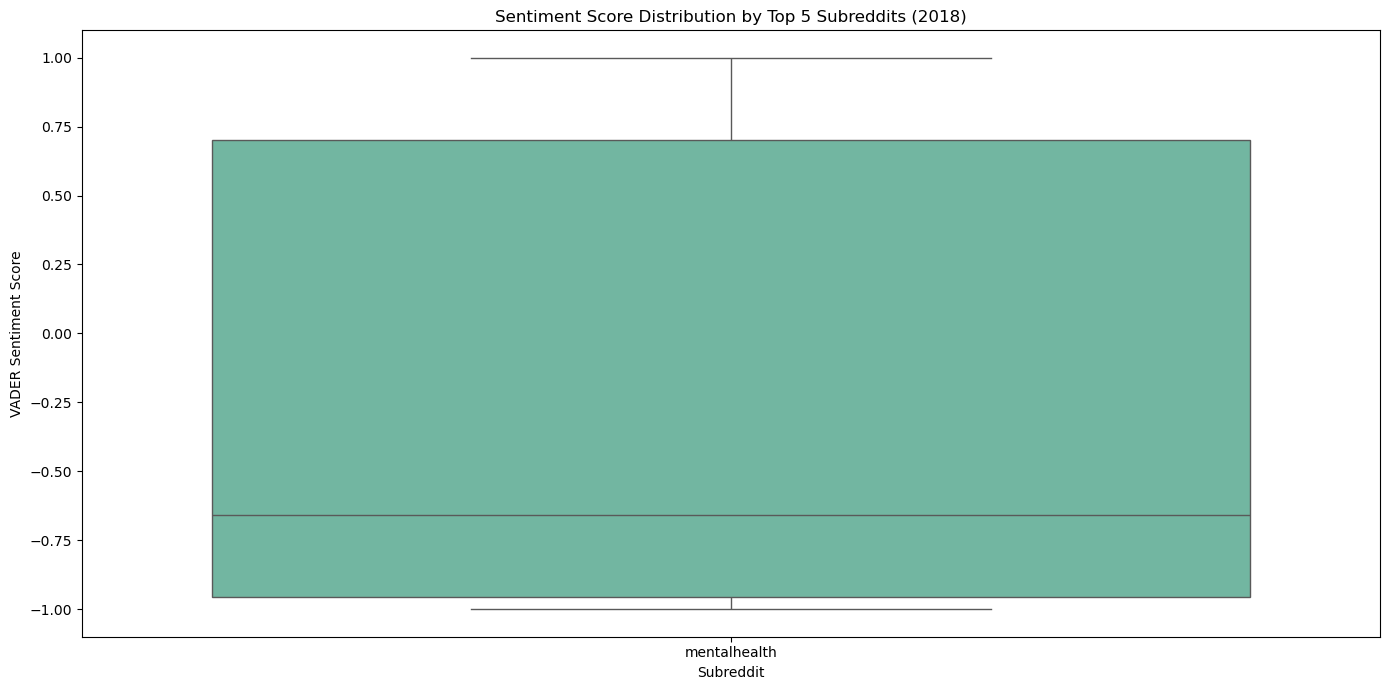

In [18]:
# Identify top 5 subreddits by post count for focused analysis
top_subreddits = reddit_df['subreddit'].value_counts().head(5).index.tolist()

plt.figure(figsize=(14,7))
# Boxplot to show sentiment score distribution within each of the top subreddits
sns.boxplot(data=reddit_df[reddit_df['subreddit'].isin(top_subreddits)],
            x='subreddit', y='sentiment_score', palette='Set2')
plt.title("Sentiment Score Distribution by Top 5 Subreddits (2018)")
plt.xlabel("Subreddit")
plt.ylabel("VADER Sentiment Score")
plt.tight_layout()
plt.savefig("reddit_subreddit_sentiment_boxplot.png")
plt.show()

In [19]:
# Calculate and print average sentiment for these subreddits
avg_sentiment_subs = reddit_df.groupby('subreddit')['sentiment_score'].mean().loc[top_subreddits]
print("\nAverage Sentiment Scores of Top 5 Subreddits:")
print(avg_sentiment_subs)


Average Sentiment Scores of Top 5 Subreddits:
subreddit
mentalhealth   -0.23111
Name: sentiment_score, dtype: float64



# 11. Summary statistics for reporting

In [20]:
print("\nSummary Statistics for Sentiment Scores on Reddit Posts:")
print(reddit_df['sentiment_score'].describe())

print("\nSummary Statistics for Google Trends Search Interests:")
print(google_df[['mental health', 'depression', 'therapy', 'suicide help']].describe())


Summary Statistics for Sentiment Scores on Reddit Posts:
count    3360.000000
mean       -0.231110
std         0.792675
min        -0.999900
25%        -0.954300
50%        -0.657200
75%         0.700300
max         0.999100
Name: sentiment_score, dtype: float64

Summary Statistics for Google Trends Search Interests:
       mental health  depression    therapy  suicide help
count      51.000000   51.000000  51.000000          50.0
mean       15.019608   28.000000  56.980392           0.5
std         2.611438    2.675818   2.887838           0.0
min        10.000000   21.000000  51.000000           0.5
25%        13.000000   26.000000  55.000000           0.5
50%        15.000000   28.000000  57.000000           0.5
75%        17.000000   30.000000  59.000000           0.5
max        22.000000   33.000000  63.000000           0.5


# 13. Save cleaned datasets for future reproducibility and analysis

In [21]:

reddit_df.to_csv('reddit_mentalhealth_cleaned.csv', index=False)
google_df.to_csv('google_trends_cleaned.csv', index=False)